In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
import warnings
import plotly.express as px

In [2]:
df = pd.read_csv('./NFLX.csv')

In [3]:
dataset = pd.DataFrame(df.reset_index()["Close"])
data = dataset.values
data = data.astype('float32')

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [5]:
train_size = int(len(data)*0.8)
test_size = len(data)-train_size 
train, test = data[0:train_size,:], data[train_size:len(data),:] 
print(len(train), len(test))

807 202


In [6]:
# function to take 
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
     a = dataset[i:(i+look_back), 0]
     dataX.append(a)
     dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

# train and test set
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back) 

# reshape the X and y data
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(805, 1, 1) (805,) (200, 1, 1) (200,)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainX = torch.tensor(trainX, dtype=torch.float32).to(device)
trainY = torch.tensor(trainY, dtype=torch.float32).to(device)
testX = torch.tensor(testX, dtype=torch.float32).to(device)
testY = torch.tensor(testY, dtype=torch.float32).to(device)

In [8]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=4, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), 4).to(device)  # Hidden state
        c_0 = torch.zeros(1, x.size(0), 4).to(device)  # Cell state
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Take the last output of the sequence
        return out


In [9]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
model = LSTMModel().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 800
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(trainX)
    loss = criterion(outputs, trainY.unsqueeze(1))
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [10/800], Loss: 0.0667
Epoch [20/800], Loss: 0.0597
Epoch [30/800], Loss: 0.0534
Epoch [40/800], Loss: 0.0477
Epoch [50/800], Loss: 0.0428
Epoch [60/800], Loss: 0.0386
Epoch [70/800], Loss: 0.0352
Epoch [80/800], Loss: 0.0326
Epoch [90/800], Loss: 0.0306
Epoch [100/800], Loss: 0.0291
Epoch [110/800], Loss: 0.0280
Epoch [120/800], Loss: 0.0272
Epoch [130/800], Loss: 0.0265
Epoch [140/800], Loss: 0.0259
Epoch [150/800], Loss: 0.0253
Epoch [160/800], Loss: 0.0247
Epoch [170/800], Loss: 0.0240
Epoch [180/800], Loss: 0.0234
Epoch [190/800], Loss: 0.0228
Epoch [200/800], Loss: 0.0222
Epoch [210/800], Loss: 0.0215
Epoch [220/800], Loss: 0.0209
Epoch [230/800], Loss: 0.0202
Epoch [240/800], Loss: 0.0195
Epoch [250/800], Loss: 0.0188
Epoch [260/800], Loss: 0.0181
Epoch [270/800], Loss: 0.0174
Epoch [280/800], Loss: 0.0167
Epoch [290/800], Loss: 0.0160
Epoch [300/800], Loss: 0.0153
Epoch [310/800], Loss: 0.0145
Epoch [320/800], Loss: 0.0138
Epoch [330/800], Loss: 0.0131
Epoch [340/800], Lo

In [10]:
# Predictions
model.eval()
trainPredict = model(trainX).detach().cpu().numpy()
testPredict = model(testX).detach().cpu().numpy()

# Inverse transform predictions and actual values
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY.cpu().numpy().reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.cpu().numpy().reshape(-1, 1))

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.72 RMSE
Test Score: 15.84 RMSE


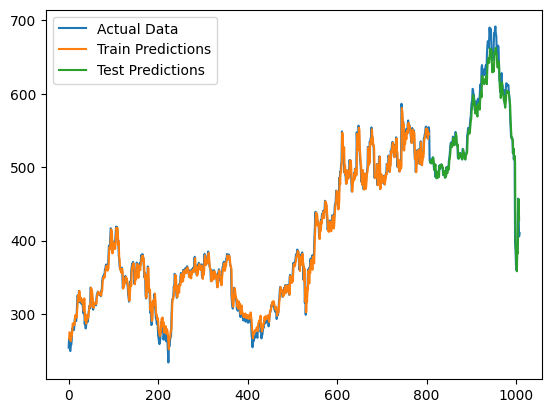

In [11]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(data) - 1, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(data), label="Actual Data")
plt.plot(trainPredictPlot, label="Train Predictions")
plt.plot(testPredictPlot, label="Test Predictions")
plt.legend()
plt.show()
